<ipython-input-2-3fa9b5232922>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'1': 1, '4': 0})
<ipython-input-2-3fa9b5232922>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'1': 1, '4': 0})
<ipython-input-2-3fa9b5232922>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

Perc rows removed class 1: 0.14428088463163827
Perc rows removed class 0: 0.12013093289689035
Perc rows removed class 1: -0.17638585950039096
Perc rows removed class 0: -0.07412574404761904
Data has been split, outliers removed, and data scaled.
Class distribution after SMOTE: auop
1    20013
0    20013
Name: count, dtype: int64
Final Model Cohen's Kappa: 0.5000038057935856
Final Model Misclassification Error: 0.2090654067621438
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      4071
           1       0.85      0.85      0.85      9379

    accuracy                           0.79     13450
   macro avg       0.75      0.75      0.75     13450
weighted avg       0.79      0.79      0.79     13450

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      4071
           1       0.85      0.85      0.85      9379

    accuracy                           0.79     13450
   macro avg       0.7

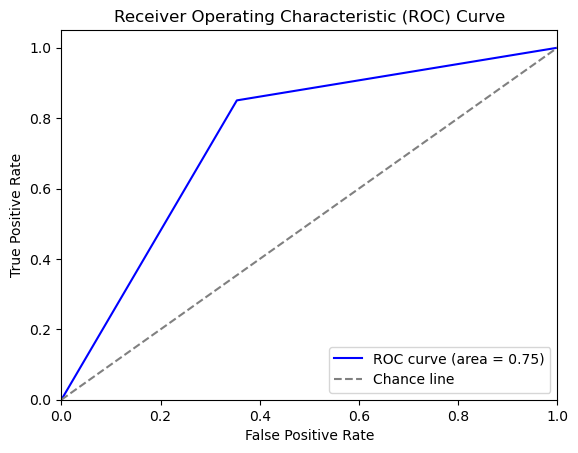

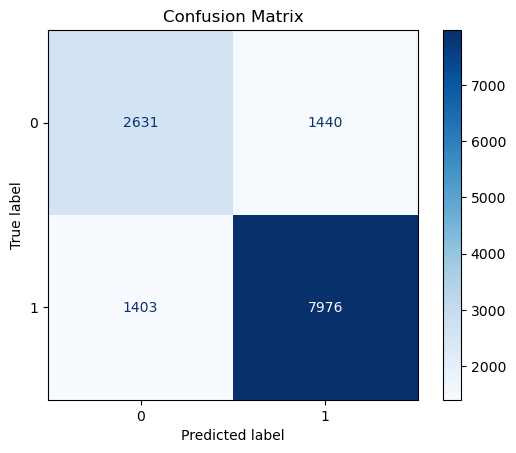

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.optimize import differential_evolution  # for comparison to SCA
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import shap
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

#from base1 import *
from base2 import *
from XGB_func import *

X_train_1 = pd.read_csv('csv/X_train.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/y_train.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/X_val.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/y_val.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/X_test.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/y_test.csv', index_col='Unnamed: 0')

y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)

y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})

X_train = X_train_1
X_val = X_val_1
X_test = X_test_1 

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder on X_train and transform on all sets to ensure consistency
X_train['X141'] = label_encoder.fit_transform(X_train['X140'])
X_val['X141'] = label_encoder.transform(X_val['X140'])
X_test['X141'] = label_encoder.transform(X_test['X140'])
# Drop column 'X140' from each DataFrame
X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])

col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X141")

# remove outliers
col_25perc = round(len(X_train.columns)*0.25)
total_class = y_train.value_counts().to_dict()
X_train, y_train, removed_counts = k.remove_outliers_iqr(X_train, y_train, col_names, min_outliers= col_25perc)
print("Perc rows removed class 1:", removed_counts[1]/total_class[1])
print("Perc rows removed class 0:", removed_counts[0]/total_class[0])


# Deal with missing values
max_missing = col_25perc
X_train = X_train[X_train.isnull().sum(axis=1) < max_missing]
y_train = y_train.loc[X_train.index]
new_total_class = y_train.value_counts().to_dict()
print("Perc rows removed class 1:", (new_total_class[1]-(total_class[1]-removed_counts[1]))/(total_class[1]-removed_counts[1]))
print("Perc rows removed class 0:", (new_total_class[0]-(total_class[0]-removed_counts[0]))/(total_class[0]-removed_counts[0]))

# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Scale the data
X_train, X_val, X_test = k.scale_columns1(X_train, X_val, X_test, col_names)
print("Data has been split, outliers removed, and data scaled.")

# Use SMOTE to oversample the minority class in the training set
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", pd.Series(y_train.value_counts()))

# Run the sine cosine algorithm to find the best hyperparameters 
#best_params = sine_cosine_algorithm(X_train, y_train, X_val, y_val, max_iter=30, pop_size=20, early_stopping_rounds=10)
# Print the best hyperparameters found by the algorithm
#print("Best hyperparameters found by SCA:")
#print(best_params)

best_params = {'learning_rate': 0.059064262532013245, 'max_depth': 9.600161620259907, 'subsample': 0.9433198324637911, 'colsample_bytree': 0.6304129803726312, 'reg_alpha': 0.7670677469979941, 'reg_lambda': 0.0}

# Train the final model using the best parameters
final_kappa, final_misclass_error, final_model = train_xgboost(X_train, y_train, X_val, y_val, best_params)

# Output final model evaluation
print(f"Final Model Cohen's Kappa: {final_kappa}")
print(f"Final Model Misclassification Error: {final_misclass_error}")
# Evalute 
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))


# Save the trained XGBoost model
final_model.save_model("xgboost_modelSM_V1112.json")
# Load the saved XGBoost model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgboost_modelSM_V1112.json")
# Verify by running predictions
y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded))


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y_test
y_pred_proba = y_pred 
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)


# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("hierboven met smote hieronder zonder")

hierboven met smote hieronder zonder


<ipython-input-4-b7df5d7b07ee>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'1': 1, '4': 0})
<ipython-input-4-b7df5d7b07ee>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'1': 1, '4': 0})
<ipython-input-4-b7df5d7b07ee>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

Perc rows removed class 1: 0.14428088463163827
Perc rows removed class 0: 0.12013093289689035
Perc rows removed class 1: -0.17638585950039096
Perc rows removed class 0: -0.07412574404761904
Data has been split, outliers removed, and data scaled.
Final Model Cohen's Kappa: 0.5286512461810902
Final Model Misclassification Error: 0.1830060534475122
              precision    recall  f1-score   support

           0       0.77      0.56      0.65      4071
           1       0.83      0.93      0.88      9379

    accuracy                           0.82     13450
   macro avg       0.80      0.74      0.76     13450
weighted avg       0.81      0.82      0.81     13450

              precision    recall  f1-score   support

           0       0.77      0.56      0.65      4071
           1       0.83      0.93      0.88      9379

    accuracy                           0.82     13450
   macro avg       0.80      0.74      0.76     13450
weighted avg       0.81      0.82      0.81     13450

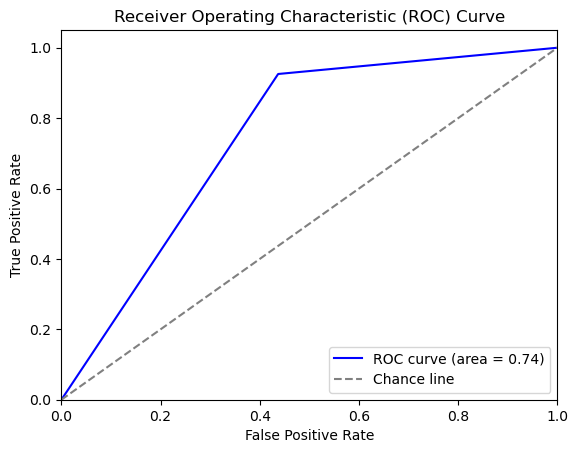

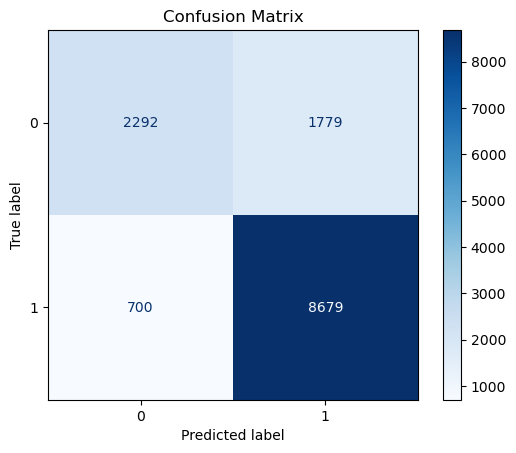

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.optimize import differential_evolution  # for comparison to SCA
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import shap
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

#from base1 import *
from base2 import *
from XGB_func import *

X_train_1 = pd.read_csv('csv/X_train.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/y_train.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/X_val.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/y_val.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/X_test.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/y_test.csv', index_col='Unnamed: 0')

y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)

y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})

X_train = X_train_1
X_val = X_val_1
X_test = X_test_1 

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder on X_train and transform on all sets to ensure consistency
X_train['X141'] = label_encoder.fit_transform(X_train['X140'])
X_val['X141'] = label_encoder.transform(X_val['X140'])
X_test['X141'] = label_encoder.transform(X_test['X140'])
# Drop column 'X140' from each DataFrame
X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])

col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X141")

# remove outliers
col_25perc = round(len(X_train.columns)*0.25)
total_class = y_train.value_counts().to_dict()
X_train, y_train, removed_counts = k.remove_outliers_iqr(X_train, y_train, col_names, min_outliers= col_25perc)
print("Perc rows removed class 1:", removed_counts[1]/total_class[1])
print("Perc rows removed class 0:", removed_counts[0]/total_class[0])


# Deal with missing values
max_missing = col_25perc
X_train = X_train[X_train.isnull().sum(axis=1) < max_missing]
y_train = y_train.loc[X_train.index]
new_total_class = y_train.value_counts().to_dict()
print("Perc rows removed class 1:", (new_total_class[1]-(total_class[1]-removed_counts[1]))/(total_class[1]-removed_counts[1]))
print("Perc rows removed class 0:", (new_total_class[0]-(total_class[0]-removed_counts[0]))/(total_class[0]-removed_counts[0]))

# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Scale the data
X_train, X_val, X_test = k.scale_columns1(X_train, X_val, X_test, col_names)
print("Data has been split, outliers removed, and data scaled.")

# Use SMOTE to oversample the minority class in the training set
#smote = SMOTE()
#X_train, y_train = smote.fit_resample(X_train, y_train)
#print("Class distribution after SMOTE:", pd.Series(y_train.value_counts()))

# Run the sine cosine algorithm to find the best hyperparameters 
#best_params = sine_cosine_algorithm(X_train, y_train, X_val, y_val, max_iter=30, pop_size=20, early_stopping_rounds=10)
# Print the best hyperparameters found by the algorithm
#print("Best hyperparameters found by SCA:")
#print(best_params)

best_params = {'learning_rate': 0.059064262532013245, 'max_depth': 9.600161620259907, 'subsample': 0.9433198324637911, 'colsample_bytree': 0.6304129803726312, 'reg_alpha': 0.7670677469979941, 'reg_lambda': 0.0}

# Train the final model using the best parameters
final_kappa, final_misclass_error, final_model = train_xgboost(X_train, y_train, X_val, y_val, best_params)

# Output final model evaluation
print(f"Final Model Cohen's Kappa: {final_kappa}")
print(f"Final Model Misclassification Error: {final_misclass_error}")
# Evalute 
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))


# Save the trained XGBoost model
final_model.save_model("xgboost_modelSM_V1112.json")
# Load the saved XGBoost model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgboost_modelSM_V1112.json")
# Verify by running predictions
y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded))


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y_test
y_pred_proba = y_pred 
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)


# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()